# Init

In [1]:
# IMPORT ALL LIB 
import subprocess
import numpy as np  
import matplotlib.pyplot as plt 

#%pip install pyvisa
#%pip install pyvisa-py
import pyvisa  
print("pyvisa==",pyvisa.__version__)

pyvisa== 1.15.0


In [2]:
# The IP of the PC 
result = subprocess.run(["ipconfig"], capture_output=True, text=True)
output =result.stdout
arr=output.split("\n")
for i,l in enumerate (arr):
    if "Ethernet adapter Ethernet:" in l:
        break
for j in range(i,i+7):
    l= arr[j]
    print(l)

Ethernet adapter Ethernet:

   Connection-specific DNS Suffix  . : 
   Link-local IPv6 Address . . . . . : fe80::5481:6a10:a56d:aec%19
   Autoconfiguration IPv4 Address. . : 169.254.104.97
   Subnet Mask . . . . . . . . . . . : 255.255.0.0
   Default Gateway . . . . . . . . . : 


In [3]:
scope_ip = "169.254.104.98" 
scope_ip = '169.254.104.98'

In [4]:


def ping_oscilloscope(ip="169.254.229.238", count=1):
    try:
        result = subprocess.run(
            ["ping", "-n", str(count), ip],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,  # decode output as text
            shell=True
        )
        if result.returncode == 0:
            print("Ping successful:")
        else:
            print("Ping failed:")
        print(result.stdout)
    except Exception as e:
        print("Error pinging oscilloscope:", e)

ping_oscilloscope(ip = scope_ip )

Ping successful:

Pinging 169.254.104.98 with 32 bytes of data:
Reply from 169.254.104.98: bytes=32 time=170ms TTL=255

Ping statistics for 169.254.104.98:
    Packets: Sent = 1, Received = 1, Lost = 0 (0% loss),
Approximate round trip times in milli-seconds:
    Minimum = 170ms, Maximum = 170ms, Average = 170ms



In [5]:
rm = pyvisa.ResourceManager('@py') # Use pyvisa-py backend  

 
resource_str = f"TCPIP::{scope_ip}::INSTR"  
try:  
    scope.close()  
except: pass  
try:  
    scope = rm.open_resource(resource_str)  
    print("Connected to:", scope.query("*IDN?"))  
except Exception as e:  
    print("Connection failed:", e)  

Connected to: TEKTRONIX,TDS 3034B,0,CF:91.1CT FV:v3.35 TDS3FFT:v1.00 TDS3TRG:v1.00



In [6]:
def det_data(chanel = "CH1"): 
    scope.write("DATA:SOURCE "+chanel)  
    # Set binary format  
    scope.write("DATA:ENC RIB") # Signed binary  
    scope.write("DATA:WIDTH 2") # 2 byte per point  
    
    # Read waveform settings for scaling  
    x_increment = float(scope.query("WFMPRE:XINCR?"))  
    x_origin = float(scope.query("WFMPRE:XZERO?"))  
    y_increment = float(scope.query("WFMPRE:YMULT?"))  
    y_origin = float(scope.query("WFMPRE:YZERO?"))  
    y_offset = float(scope.query("WFMPRE:YOFF?"))  
    
    
    # set your desired record length  
    scope.write("DATA:START 1")  
    scope.write("DATA:STOP 10000")  
    
    # this issues the CURVE? query and returns a numpy int16 array  
    raw = scope.query_binary_values(  
    'CURVE?',  
    datatype='h', # 'h' = signed 16‑bit  
    is_big_endian=True, # or False depending on your scope  
    container=np.array  
    )  
    
    
    # Convert bytes to numpy array  
    wave = np.array( raw)  
    
    # Scale data  
    voltages = (wave - y_offset) * y_increment + y_origin  
    
    times = np.arange(len(voltages)) * x_increment + x_origin 
    return times, voltages
#det_data(chanel = "CH1")

In [7]:
def get_active_channels():
    active_channels = []
    for i in range(1, 5):  # assuming up to CH4
        try:
            response = scope.query(f"SELECT:CH{i}?").strip()
            if response in ['1', 'ON']:  # depending on oscilloscope
                active_channels.append(f"CH{i}")
        except Exception as e:
            print(f"Error querying CH{i}: {e}")
    return active_channels
chanels = get_active_channels()
#chanels

In [8]:
#chanels = ['CH1', 'CH2']
def get_probe_config(chanels): 
    #params = ["PROBe", "IMPEDANCE", "COUPLING"]
    params = ["PROBe", "IMPEDANCE", "COUPLING", 
              "OFFSET", "POSITION", "BANDWIDTH", "INVERT", "SCALE"]
    DIC = {}
    for c in chanels: 
        dic ={}
        cu= c.upper()
        for p in params: 
            try:
                dic[p]= scope.query(cu+":"+p+"?")#.replace("\n", "")
            except: pass
        DIC[c]= dic
    params = ["HORIZONTAL:MAIN:SCALE?", "WFMPRE:NR_Pt?"]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p)#.replace("\n", "")
        except: pass
    DIC["general"]= dic


    params = [
        "TRIGger:STATE?",
        "TRIGger:MAIn:EDGE:SOURce?",
        "TRIGger:MAIn:EDGE:SLOPe?",
        "TRIGger:MAIn:EDGE:COUPling?",
        "TRIGger:MAIn:LEVel?"
    ]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p).replace("\n", "")
        except: pass
    DIC["trigger"]= dic
    
    return DIC
#get_probe_config(chanels)

In [9]:
def get_meas():
    arr = {}
    for i in range(1,5):  
        data, status = scope.query(f"MEASurement:MEAS{i}:DATA?").split(',')  
        mtype = scope.query(f"MEASurement:MEAS{i}:TYPE?").strip()
        source = scope.query(f"MEASurement:MEAS{i}:SOURCE1?").strip()
        if int(status) ==0:  
            #print("#", source,mtype, data)  
            try:
                arr[source][mtype]=data
            except:
                arr[source] = {mtype:data}

    return arr
#get_meas()              

In [10]:
import json


def get_params_txt(title=None):
    chanels = get_active_channels()
    dic  =get_probe_config(chanels)
    dic["measurements"]= get_meas() 
    if title is not None: 
        # Save to JSON file
        with open(title+".json", "w") as f:
            json.dump(dic, f, indent=4)
    return dic 
#_= get_params_txt("test")
#_

In [11]:
import pandas as pd 
def get_signals(title):
    chanels = get_active_channels()
    DIC = {}
    for c in chanels: 
        dic ={}
        cu= c.upper()
        time, voltage = det_data(chanel = cu)
        DIC["time"]= time
        DIC[cu]= voltage
    df = pd.DataFrame(DIC)
    df.to_csv(title+".csv", index = False) 
    return df


# MEAS

In [ ]:
from datetime import datetime
import requests


# Make timestamp
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S") + f"-{int(now.microsecond/1000):03d}"
print(timestamp)


In [40]:
import numpy as np  
import matplotlib.pyplot as plt 
import json

#%pip install pyvisa
#%pip install pyvisa-py
import pyvisa  
#print("pyvisa==",pyvisa.__version__)

In [41]:
scope_ip = '169.254.104.98'

In [42]:
rm = pyvisa.ResourceManager('@py') # Use pyvisa-py backend  

 
resource_str= f"TCPIP::{scope_ip}::INSTR"  
try:  
    scope.close()  
except: pass  
try:  
    scope = rm.open_resource(resource_str)  
    print("Connected to:", scope.query("*IDN?"))  
except Exception as e:  
    print("Connection failed:", e)  

Connected to: TEKTRONIX,TDS 3034B,0,CF:91.1CT FV:v3.35 TDS3FFT:v1.00 TDS3TRG:v1.00



In [50]:
def get_active_channels():
    active_channels = []
    for i in range(1, 5):  # assuming up to CH4
        try:
            response = scope.query(f"SELECT:CH{i}?").strip()
            response = response.split(" ")[-1]
            print(f"CH{i}", response)
            if response in ['1', 'ON']:  # depending on oscilloscope
                active_channels.append(f"CH{i}")
        except Exception as e:
            print(f"Error querying CH{i}: {e}")
    return active_channels
chanels = get_active_channels()
print(chanels)

CH1 1
CH2 1
CH3 1
CH4 0
['CH1', 'CH2', 'CH3']


In [54]:
def get_general_config(): 

    DIC = {}

    params = ["HORIZONTAL:MAIN:SCALE?", "WFMPRE:NR_Pt?"]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p)#.replace("\n", "")
        except: pass
    DIC["general"]= dic


    params = [
        "TRIGger:STATE?",
        "TRIGger:MAIn:EDGE:SOURce?",
        "TRIGger:MAIn:EDGE:SLOPe?",
        "TRIGger:MAIn:EDGE:COUPling?",
        "TRIGger:MAIn:LEVel?"
    ]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p).replace("\n", "")
        except: pass
    DIC["trigger"]= dic
    
    return DIC
d = get_general_config()
print(d)

{'general': {'HORIZONTAL:MAIN:SCALE?': ':HORIZONTAL:MAIN:SCALE 4.0E-6\n', 'WFMPRE:NR_Pt?': ':WFMPRE:NR_PT 10000\n'}, 'trigger': {'TRIGger:STATE?': ':TRIGGER:STATE AUTO', 'TRIGger:MAIn:EDGE:SOURce?': ':TRIGGER:MAIN:EDGE:SOURCE CH1', 'TRIGger:MAIn:EDGE:SLOPe?': ':TRIGGER:MAIN:EDGE:SLOPE RISE', 'TRIGger:MAIn:EDGE:COUPling?': ':TRIGGER:MAIN:EDGE:COUPLING DC', 'TRIGger:MAIn:LEVel?': ':TRIGGER:MAIN:LEVEL 1.8E-1'}}


In [88]:
def get_raw_data(channel = "CH1"): 
    channel = channel .upper()

    dic ={}
    dic["channel"]= channel

    
    scope.write("DATA:SOURCE "+channel)  
    # Set binary format  
    scope.write("DATA:ENC RIB") # Signed binary  
    scope.write("DATA:WIDTH 2") # 2 byte per point  
    
    # Read waveform settings for scaling  
    x_increment = scope.query("WFMPRE:XINCR?")
    x_origin = scope.query("WFMPRE:XZERO?") 
    y_increment = scope.query("WFMPRE:YMULT?")
    y_origin = scope.query("WFMPRE:YZERO?")  
    y_offset = scope.query("WFMPRE:YOFF?")
    dic["x_increment"]= x_increment
    dic["x_origin"]= x_origin
    dic["y_increment"]= y_increment
    dic["y_origin"]= y_origin
    dic["y_offset"]= y_offset
    
    
    # set your desired record length  
    scope.write("DATA:START 1")  
    scope.write("DATA:STOP 10000")  
    
    # this issues the CURVE? query and returns a numpy int16 array  
    raw = scope.query_binary_values(  
    'CURVE?',  
    datatype='h', # 'h' = signed 16‑bit  
    is_big_endian=True, # or False depending on your scope  
    container=np.array  
    )  
    
    
    # Convert bytes to numpy array  
    wave = np.array( raw)  
    # Scale data  
    #voltages = (wave - y_offset) * y_increment + y_origin  
    #times = np.arange(len(voltages)) * x_increment + x_origin 
    dic["raw_data"]= raw
    
    # Scale data  
    #voltages = (wave - y_offset) * y_increment + y_origin  
    #times = np.arange(len(voltages)) * x_increment + x_origin 



    params = ["PROBe", "IMPEDANCE", "COUPLING", 
              "OFFSET", "POSITION", "BANDWIDTH", "INVERT", "SCALE"]


    for p in params: 
        try:
            dic[p]= scope.query(channel+":"+p+"?")#.replace("\n", "")
        except: pass
    

        
    return dic# times, voltages

d = get_raw_data(channel = "CH1")
print(d.keys())

dict_keys(['channel', 'x_increment', 'x_origin', 'y_increment', 'y_origin', 'y_offset', 'raw_data', 'PROBe', 'IMPEDANCE', 'COUPLING', 'OFFSET', 'POSITION', 'BANDWIDTH', 'INVERT', 'SCALE'])


array([-6403, -6785, -6528, ..., -6274, -6530, -6784],
      shape=(10000,), dtype=int16)

In [83]:
from datetime import datetime
import requests


# Make timestamp
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S") + f"-{int(now.microsecond/1000):03d}"
print(timestamp)

2025-11-11_20-08-17-260


In [109]:
chanels = get_active_channels()
res={}
res["general_config"]= get_general_config()
channels = get_active_channels()
for channel in channels: 
    res[channel]= get_raw_data(channel = channel)
    lis= list(res[channel]['raw_data'].astype("int16"))
    lis =[int(x) for x in lis]
    res[channel]['raw_data'] = lis
    
import pprint
with open(f"{timestamp}.txt", "w") as f:
    #f.write(str(res))
    f.write(pprint.pformat(res))



CH1 1
CH2 1
CH3 1
CH4 0
CH1 1
CH2 1
CH3 1
CH4 0


In [1]:
from datetime import datetime



# Make timestamp
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S") + f"-{int(now.microsecond/1000):03d}"
print(timestamp)


import numpy as np  


#%pip install pyvisa
#%pip install pyvisa-py
import pyvisa  
#print("pyvisa==",pyvisa.__version__)

scope_ip = '169.254.104.98'

rm = pyvisa.ResourceManager('@py') # Use pyvisa-py backend  

 
resource_str= f"TCPIP::{scope_ip}::INSTR"  
try:  
    scope.close()  
except: pass  
try:  
    scope = rm.open_resource(resource_str)  
    print("Connected to:", scope.query("*IDN?"))  
except Exception as e:  
    print("Connection failed:", e)  

def get_active_channels():
    active_channels = []
    for i in range(1, 5):  # assuming up to CH4
        try:
            response = scope.query(f"SELECT:CH{i}?").strip()
            response = response.split(" ")[-1]
            print(f"CH{i}", response)
            if response in ['1', 'ON']:  # depending on oscilloscope
                active_channels.append(f"CH{i}")
        except Exception as e:
            print(f"Error querying CH{i}: {e}")
    return active_channels
chanels = get_active_channels()
print(chanels)



def get_general_config(): 

    DIC = {}

    params = ["HORIZONTAL:MAIN:SCALE?", "WFMPRE:NR_Pt?"]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p)#.replace("\n", "")
        except: pass
    DIC["general"]= dic


    params = [
        "TRIGger:STATE?",
        "TRIGger:MAIn:EDGE:SOURce?",
        "TRIGger:MAIn:EDGE:SLOPe?",
        "TRIGger:MAIn:EDGE:COUPling?",
        "TRIGger:MAIn:LEVel?"
    ]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p).replace("\n", "")
        except: pass
    DIC["trigger"]= dic
    
    return DIC
d = get_general_config()
print(d)

def get_raw_data(channel = "CH1"): 
    channel = channel .upper()

    dic ={}
    dic["channel"]= channel

    
    scope.write("DATA:SOURCE "+channel)  
    # Set binary format  
    scope.write("DATA:ENC RIB") # Signed binary  
    scope.write("DATA:WIDTH 2") # 2 byte per point  
    
    # Read waveform settings for scaling  
    x_increment = scope.query("WFMPRE:XINCR?")
    x_origin = scope.query("WFMPRE:XZERO?") 
    y_increment = scope.query("WFMPRE:YMULT?")
    y_origin = scope.query("WFMPRE:YZERO?")  
    y_offset = scope.query("WFMPRE:YOFF?")
    dic["x_increment"]= x_increment
    dic["x_origin"]= x_origin
    dic["y_increment"]= y_increment
    dic["y_origin"]= y_origin
    dic["y_offset"]= y_offset
    
    
    # set your desired record length  
    scope.write("DATA:START 1")  
    scope.write("DATA:STOP 10000")  
    
    # this issues the CURVE? query and returns a numpy int16 array  
    raw = scope.query_binary_values(  
    'CURVE?',  
    datatype='h', # 'h' = signed 16‑bit  
    is_big_endian=True, # or False depending on your scope  
    container=np.array  
    )  
    
    
    # Convert bytes to numpy array  
    wave = np.array( raw)  
    # Scale data  
    #voltages = (wave - y_offset) * y_increment + y_origin  
    #times = np.arange(len(voltages)) * x_increment + x_origin 
    dic["raw_data"]= raw
    
    # Scale data  
    #voltages = (wave - y_offset) * y_increment + y_origin  
    #times = np.arange(len(voltages)) * x_increment + x_origin 



    params = ["PROBe", "IMPEDANCE", "COUPLING", 
              "OFFSET", "POSITION", "BANDWIDTH", "INVERT", "SCALE"]


    for p in params: 
        try:
            dic[p]= scope.query(channel+":"+p+"?")#.replace("\n", "")
        except: pass
    

        
    return dic# times, voltages

d = get_raw_data(channel = "CH1")
print(d.keys())



from datetime import datetime
import requests


# Make timestamp
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S") + f"-{int(now.microsecond/1000):03d}"
print(timestamp)

chanels = get_active_channels()
res={}
res["general_config"]= get_general_config()
channels = get_active_channels()
for channel in channels: 
    res[channel]= get_raw_data(channel = channel)
    lis= list(res[channel]['raw_data'].astype("int16"))
    lis =[int(x) for x in lis]
    res[channel]['raw_data'] = lis
    
import pprint
with open(f"{timestamp}.txt", "w") as f:
    #f.write(str(res))
    f.write(pprint.pformat(res))

print("DONNNNNNNNE")

2025-11-11_20-20-37-813
Connected to: TEKTRONIX,TDS 3034B,0,CF:91.1CT FV:v3.35 TDS3FFT:v1.00 TDS3TRG:v1.00

CH1 1
CH2 1
CH3 1
CH4 0
['CH1', 'CH2', 'CH3']
{'general': {'HORIZONTAL:MAIN:SCALE?': ':HORIZONTAL:MAIN:SCALE 4.0E-6\n', 'WFMPRE:NR_Pt?': ':WFMPRE:NR_PT 10000\n'}, 'trigger': {'TRIGger:STATE?': ':TRIGGER:STATE SAVE', 'TRIGger:MAIn:EDGE:SOURce?': ':TRIGGER:MAIN:EDGE:SOURCE CH1', 'TRIGger:MAIn:EDGE:SLOPe?': ':TRIGGER:MAIN:EDGE:SLOPE RISE', 'TRIGger:MAIn:EDGE:COUPling?': ':TRIGGER:MAIN:EDGE:COUPLING DC', 'TRIGger:MAIn:LEVel?': ':TRIGGER:MAIN:LEVEL 1.8E-1'}}
dict_keys(['channel', 'x_increment', 'x_origin', 'y_increment', 'y_origin', 'y_offset', 'raw_data', 'PROBe', 'IMPEDANCE', 'COUPLING', 'OFFSET', 'POSITION', 'BANDWIDTH', 'INVERT', 'SCALE'])
2025-11-11_20-20-38-899
CH1 1
CH2 1
CH3 1
CH4 0
CH1 1
CH2 1
CH3 1
CH4 0
DONNNNNNNNE


In [28]:
arr2= np.load("arr.npy")

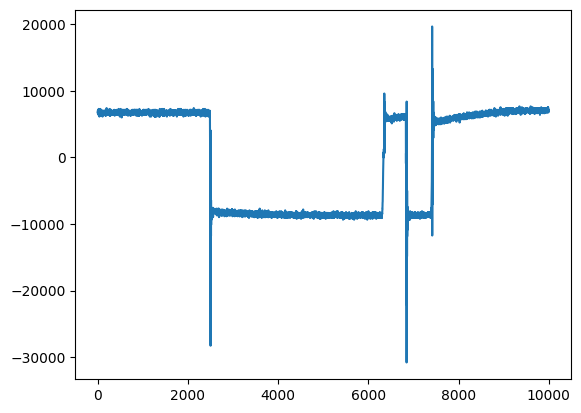

In [32]:
plt.plot(arr2[0])

In [4]:
import pandas as pd 
df = pd.read_csv("meas12.4khz.csv").astype(float)
df.head()

,time,CH2,CH4
0,-0.000055,1.54,0.146
1,-0.000055,1.51,0.142
2,-0.000055,1.52,0.146
3,-0.000055,1.51,0.150
4,-0.000055,1.52,0.148


<Axes: >

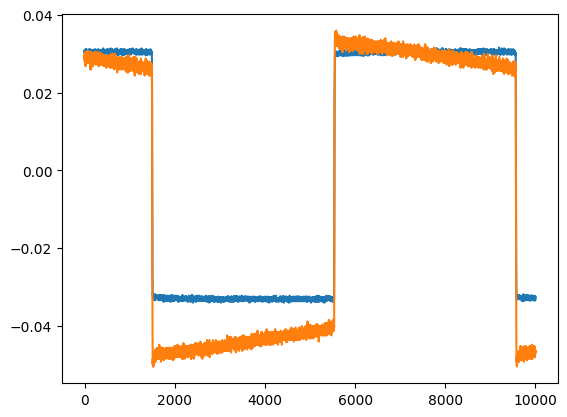

In [14]:
I_oscillo= df.CH2/50 # 50 ohm 
I_prob= df.CH4/5 # 5 turns 
I_oscillo.plot()
I_prob.plot()

<Axes: xlabel='time'>

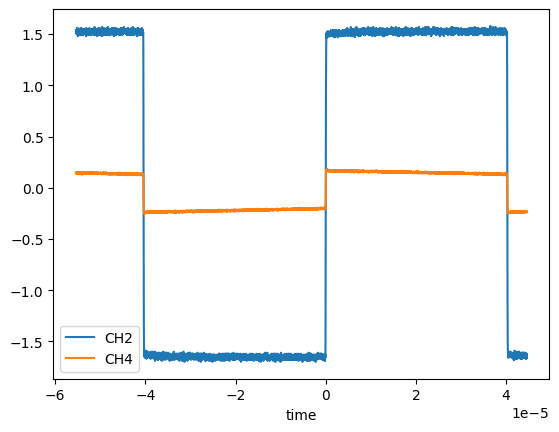

In [5]:
df.plot(x="time", y=["CH2", "CH4"  ])

In [44]:
import numpy as np

def highpass_filter(x, Ts, fc):
    """
    First-order high-pass filter using bilinear transform.

    Parameters
    ----------
    x : np.ndarray
        Input signal.
    Ts : float
        Sampling period [s].
    fc : float
        Cutoff frequency [Hz].

    Returns
    -------
    y : np.ndarray
        Filtered signal.
    """
    RC = 1 / (2 * np.pi * fc)
    alpha = RC / (RC + Ts)

    y = np.zeros_like(x)
    for n in range(1, len(x)):
        y[n] = alpha * (y[n-1] + x[n] - x[n-1])
    return y


In [51]:
import numpy as np

def highpass_filter(x, Ts, fc, y0=0.0):
    """
    First-order high-pass filter using bilinear transform.

    Parameters
    ----------
    x : np.ndarray
        Input signal.
    Ts : float
        Sampling period [s].
    fc : float
        Cutoff frequency [Hz].
    y0 : float, optional
        Initial output value (default = 0).

    Returns
    -------
    y : np.ndarray
        Filtered signal.
    """
    RC = 1 / (2 * np.pi * fc)
    alpha = RC / (RC + Ts)

    y = np.zeros_like(x, dtype=float)
    y[0] = y0
    for n in range(1, len(x)):
        y[n] = alpha * (y[n-1] + x[n] - x[n-1])
    return y


In [52]:
y = df.CH2.values

In [53]:
Ts= df.time.diff().mean()
Ts

np.float64(1e-08)

In [19]:
1/50, 0.118

(0.02, 0.118)

Text(0.5, 1.0, 'Fcut off = 800.0 Hz')

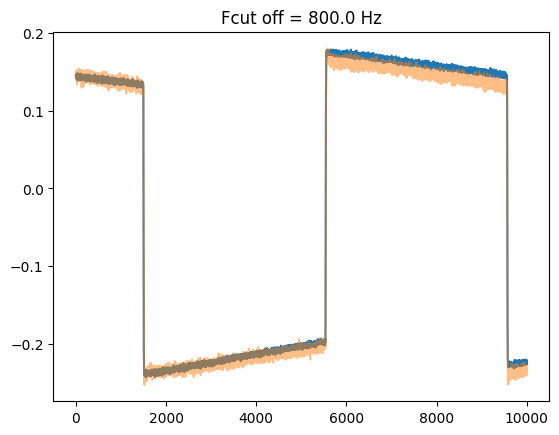

In [68]:
fcut= 0.8e3
yf= highpass_filter(x=0.118*y, Ts=Ts, fc=fcut, y0=df.CH4.iloc[0])
plt.plot(yf)
df.CH4.plot(alpha=0.5)
plt.title('Fcut off = '+str(fcut)+' Hz')

### Frequance response 

In [37]:
arr= []

In [57]:
newdic = {k + "_" + k2: v2 for k, v in get_meas().items() for k2, v2 in v.items()}
arr.append(newdic)
#arr

In [59]:
df=pd.DataFrame(arr)

In [60]:
df.head()

,CH2_AMPLITUDE,CH2_RMS,CH4_AMPLITUDE,CH4_FREQUENCY
0,6.88E0,2.46E0,2.76E-2,5.0492E1
1,6.96E0,2.491E0,5.62E-2,1.0154E2
2,7.0E0,2.5084E0,1.128E-1,2.04E2
3,7.06E0,2.5142E0,2.19E-1,4.0858E2
4,7.04E0,2.48E0,3.74E-1,7.9856E2


In [13]:
chanels = get_active_channels()
dic  =get_probe_config(chanels)
#with open("Freq_respTCP202.json", "w") as f:
#    json.dump(dic, f, indent=4)
dic

{'CH2': {'PROBe': '1.0E0',
  'IMPEDANCE': 'FIFTY',
  'COUPLING': 'DC',
  'OFFSET': '0.0E0',
  'POSITION': '3.4E-1',
  'BANDWIDTH': 'TWENTY',
  'INVERT': '0',
  'SCALE': '1.0E0'},
 'CH4': {'PROBe': '1.0E1',
  'IMPEDANCE': 'FIFTY',
  'COUPLING': 'DC',
  'OFFSET': '0.0E0',
  'POSITION': '3.8E-1',
  'BANDWIDTH': 'TWENTY',
  'INVERT': '0',
  'SCALE': '1.0E-1'},
 'general': {'HORIZONTAL:MAIN:SCALE?': '2.0E-7', 'WFMPRE:NR_Pt?': '10000'},
 'trigger': {'TRIGger:STATE?': 'SAVE',
  'TRIGger:MAIn:EDGE:SOURce?': 'CH2',
  'TRIGger:MAIn:EDGE:SLOPe?': 'RISE',
  'TRIGger:MAIn:EDGE:COUPling?': 'DC',
  'TRIGger:MAIn:LEVel?': '-5.8E-1'}}

In [110]:
#df.to_csv("Freq_respTCP202.csv",index=False)

In [1]:
import pandas as pd

In [2]:
df2= pd.read_csv("Freq_respTCP202.csv")
df2["I_AMPLITUDE"]= df2.CH2_AMPLITUDE/50 # V= RI , I= V/R
df2["I_AMP_Sensor"]= df2.CH4_AMPLITUDE/5 # 5 turns 
df2["G"]= df2["I_AMP_Sensor"]/df2["I_AMPLITUDE"]
df2.head()

,CH2_AMPLITUDE,CH2_RMS,CH4_AMPLITUDE,CH4_FREQUENCY,I_AMPLITUDE,I_AMP_Sensor,G
0,6.88,2.4600,0.0276,50.492,0.1376,0.00552,0.040116
1,6.96,2.4910,0.0562,101.540,0.1392,0.01124,0.080747
2,7.00,2.5084,0.1128,204.000,0.1400,0.02256,0.161143
3,7.06,2.5142,0.2190,408.580,0.1412,0.04380,0.310198
4,7.04,2.4800,0.3740,798.560,0.1408,0.07480,0.531250


In [3]:
df2

,CH2_AMPLITUDE,CH2_RMS,CH4_AMPLITUDE,CH4_FREQUENCY,I_AMPLITUDE,I_AMP_Sensor,G
0,6.88,2.4600,0.0276,50.492,0.1376,0.00552,0.040116
1,6.96,2.4910,0.0562,101.540,0.1392,0.01124,0.080747
2,7.00,2.5084,0.1128,204.000,0.1400,0.02256,0.161143
3,7.06,2.5142,0.2190,408.580,0.1412,0.04380,0.310198
4,7.04,2.4800,0.3740,798.560,0.1408,0.07480,0.531250
5,7.08,2.5315,0.4380,1014.600,0.1416,0.08760,0.618644
6,7.04,2.5273,0.5920,2043.300,0.1408,0.11840,0.840909
7,7.06,2.5299,0.6720,5408.300,0.1412,0.13440,0.951841
8,7.02,2.5453,0.6800,10335.000,0.1404,0.13600,0.968661
9,7.04,2.5601,0.6820,19595.000,0.1408,0.13640,0.968750


In [118]:
(df2.CH2_RMS/5).describe()

count    15.000000
mean      0.502621
std       0.008308
min       0.482100
25%       0.499810
50%       0.504560
75%       0.506140
max       0.516540
Name: CH2_RMS, dtype: float64

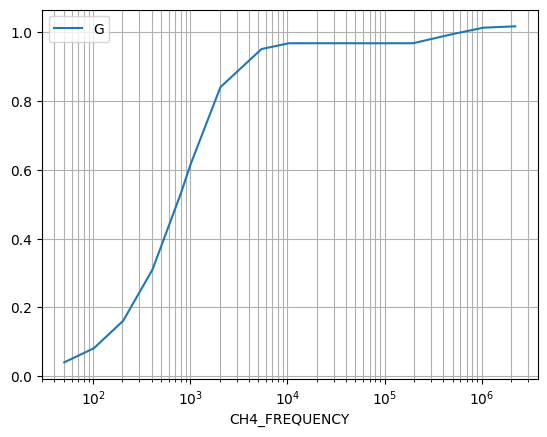

In [119]:
df2.plot(x= "CH4_FREQUENCY", y = "G")
plt.xscale("log")
plt.grid(which= "both")

In [147]:
dic = ((df2.CH2_RMS/5).describe([0.5])*1000)\
    .loc[["mean", "50%", "min","max"]].round(0).astype(int)
title= " ".join([f"{k}={v} ".replace("50%", "median") for k,v in dic.items()])
title = "Sinus input Amp=  "+title+"mA"
title

'Sinus input Amp=  mean=503  median=505  min=482  max=517 mA'

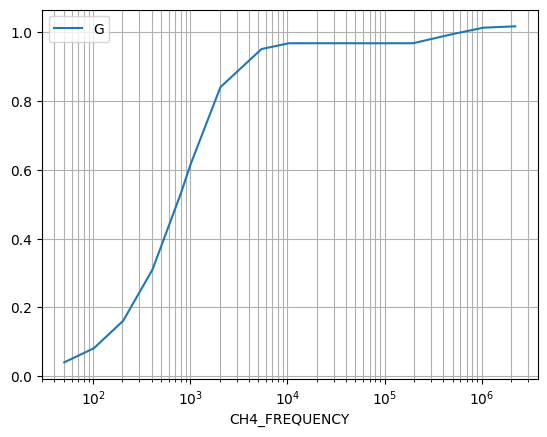

In [148]:
df2.plot(x= "CH4_FREQUENCY", y = "G")
plt.xscale("log")
plt.grid(which= "both")

Text(0, 0.5, 'Gain')

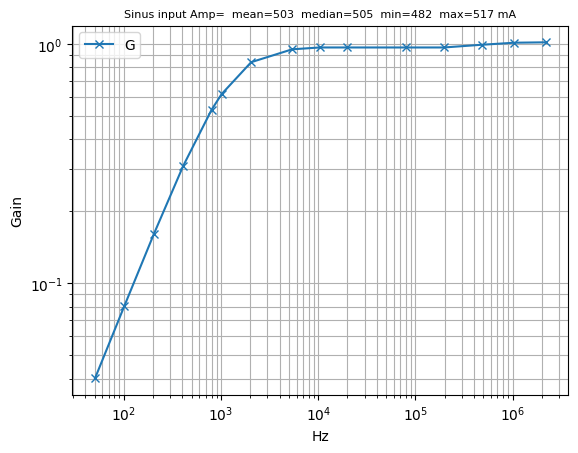

In [190]:
df2.plot(x= "CH4_FREQUENCY", y = "G", marker="x")
plt.xscale("log")
plt.yscale("log")
plt.grid(which= "both")
plt.title(title, fontsize=8)
plt.xlabel("Hz")
plt.ylabel("Gain")


Text(0, 0.9, 'Gain')

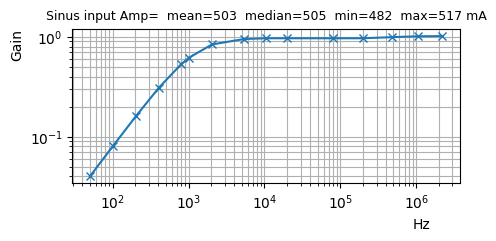

In [189]:
ax = df2.plot(
    x="CH4_FREQUENCY", 
    y="G", 
    figsize=(5,2), 
    marker="x",
    legend=False   # remove legend directly here
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(which="both")

# Title with manual position (x,y are relative in axis coords: 0=left/bottom, 1=right/top)
ax.set_title(title, fontsize=9, x=0.5, y=1.01)  

# X/Y labels with manual positions
ax.set_xlabel("Hz", x=0.9)       # move x-label more to the right
ax.set_ylabel("Gain", y=0.9)    # move y-label more to the top


### FFT methode

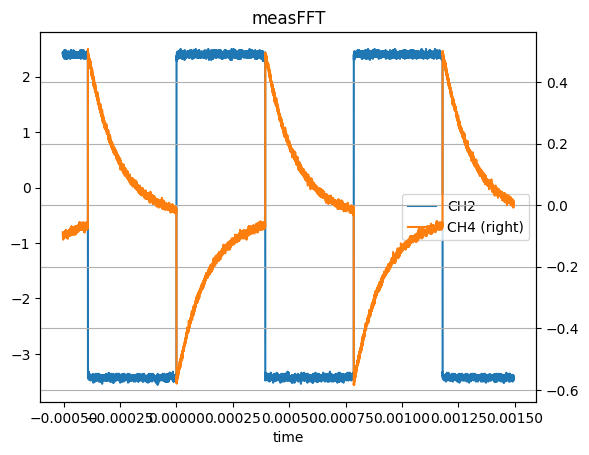

In [41]:
#read all chanels, parameters in one cmd 
title = "measFFT"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

In [47]:
df2 = pd.read_csv("measFFT.csv")

df2["I_inp"]= df2.CH2/50 # V= RI , I= V/R
df2["I_sens"]= df2.CH4/5 # 5 turns 
#df2["G"]= df2["I_AMP_Sensor"]/df2["I_AMPLITUDE"]
df2.head()

,time,CH2,CH4,I_inp,I_sens
0,-0.000504,2.42,-0.088,0.0484,-0.0176
1,-0.000504,2.42,-0.100,0.0484,-0.0200
2,-0.000504,2.44,-0.096,0.0488,-0.0192
3,-0.000503,2.40,-0.100,0.0480,-0.0200
4,-0.000503,2.40,-0.100,0.0480,-0.0200


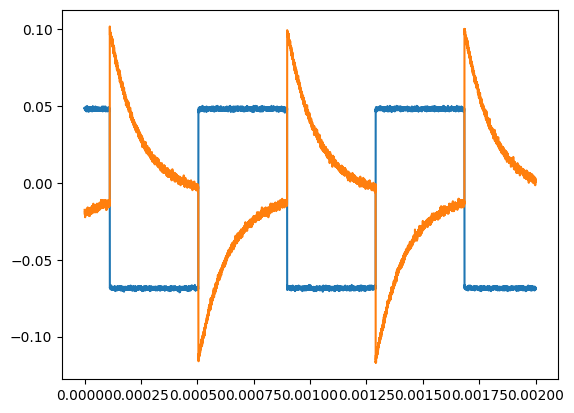

In [55]:
time = df2.time.to_numpy()
time = time-time[0]
I_inp = df2.I_inp.to_numpy()
I_sens = df2.I_sens.to_numpy()
plt.plot(time, I_inp)
plt.plot(time, I_sens )

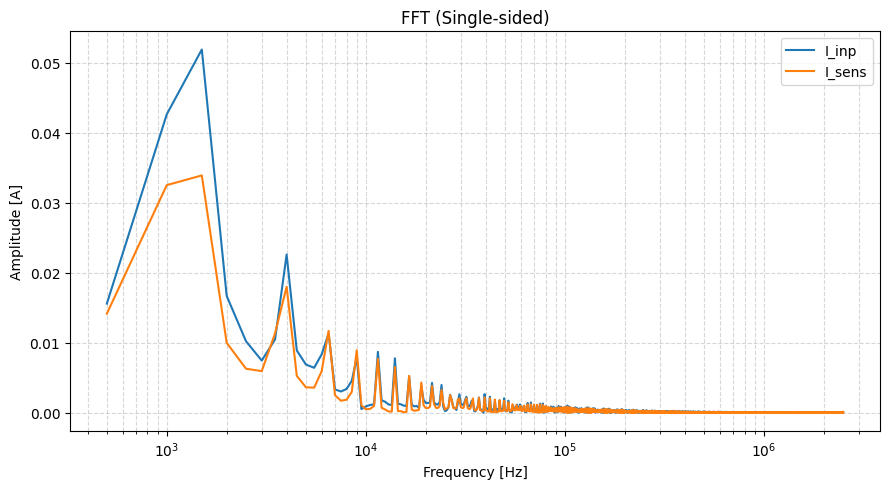

In [64]:
import numpy as np
import pandas as pd
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

# --- Load and prepare data ---
df2 = pd.read_csv("measFFT.csv")
df2["I_inp"] = df2.CH2 / 50    # V = R*I -> I = V/R
df2["I_sens"] = df2.CH4 / 5    # 5 turns

time = df2.time.to_numpy()
time = time - time[0]
I_inp = df2.I_inp.to_numpy()
I_sens = df2.I_sens.to_numpy()

Ts = np.median(np.diff(time))  # Sampling interval
Fs = 1 / Ts                    # Sampling frequency
N = len(time)

# --- FFT using SciPy ---
freqs = rfftfreq(N, Ts)
fft_inp = np.abs(rfft(I_inp)) / N * 2  # Single-sided amplitude
fft_sens = np.abs(rfft(I_sens)) / N * 2

# --- Plot ---
plt.figure(figsize=(9, 5))
plt.semilogx(freqs[1:], fft_inp[1:], label='I_inp')
plt.semilogx(freqs[1:], fft_sens[1:], label='I_sens')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [A]')
plt.title('FFT (Single-sided)')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


(0.0, 2.0)

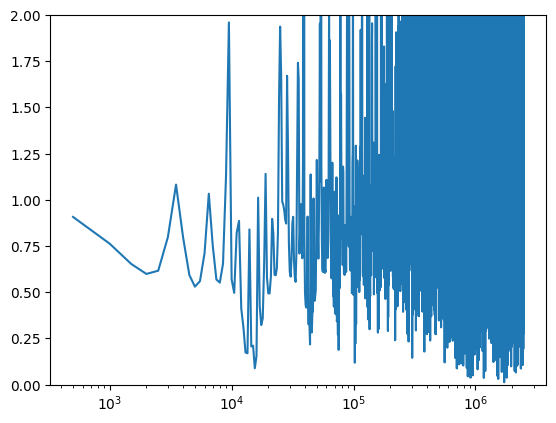

In [69]:

plt.semilogx(freqs[1:], fft_sens[1:]/fft_inp[1:], label='I_sens')
plt.ylim([0,2])

In [70]:
import numpy as np
from scipy.signal import find_peaks

def find_signal_peaks(signal, min_distance=10, height=None):
    peaks_idx, _ = find_peaks(signal, distance=min_distance, height=height)
    peaks_val = signal[peaks_idx]
    return peaks_idx, peaks_val

# Example usage:
# peaks_idx, peaks_val = find_signal_peaks(fft_inp, min_distance=20)
# print("Peak indices:", peaks_idx)
# print("Peak values:", peaks_val)


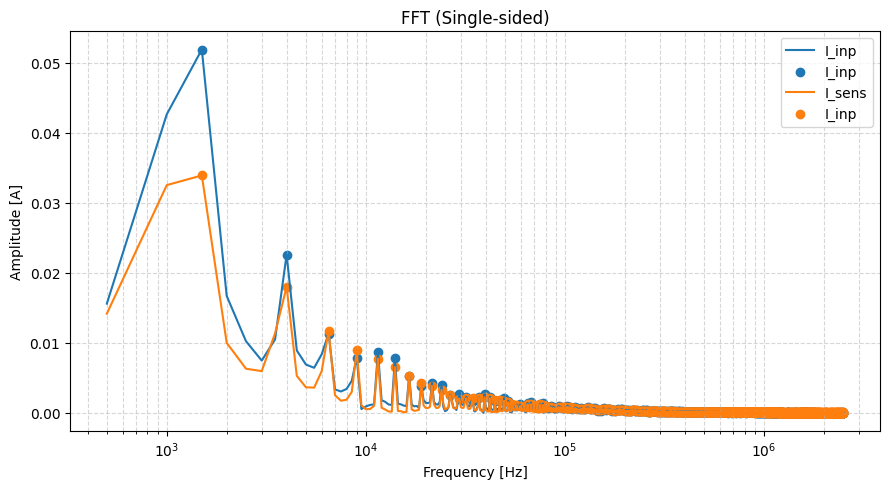

In [103]:
# --- Plot ---
plt.figure(figsize=(9, 5))

y1= fft_inp[1:]
x1=freqs[1:]
plt.semilogx(x1, y1, label='I_inp')
indx1, vals1= find_signal_peaks(signal=y, min_distance=5)
peaks1= y1[indx1]
xpeak1 = x1[indx1]
plt.scatter(xpeak1,peaks1, label='I_inp')

y2=fft_sens[1:]
plt.semilogx(x1, y2, label='I_sens')
indx2, vals2= find_signal_peaks(signal=y, min_distance=5)
peaks2= y2[indx2]
xpeak2 = x1[indx2]
plt.scatter(xpeak2,peaks2, label='I_inp')


plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [A]')
plt.title('FFT (Single-sided)')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

(0.0, 2.0)

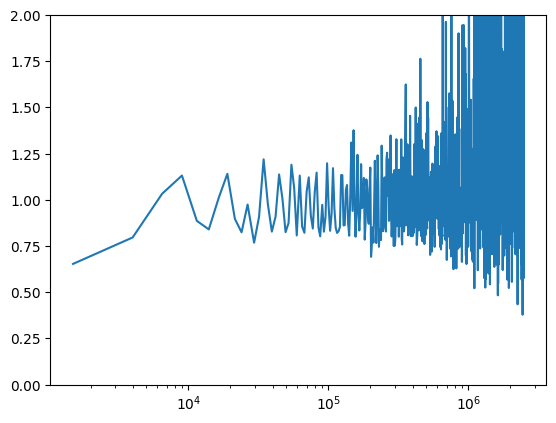

In [108]:
indx  =list(set(indx2).intersection(set(indx1)))
indx.sort()

G = y2[indx] /y1[indx]

xpeak = x1[indx]
plt.semilogx(xpeak, G, label='I_sens')
plt.ylim ([0,2])